In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from svetlanna import phase_retrieval
from svetlanna import SimulationParameters
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna import LinearOpticalSetup

Consider an optical system consisting of a source generating a Gaussian beam, a collecting lens, and a screen located in the rear focal plane of the lens. 

First, let us solve the forward problem and see what intensity distribution will be obtained if a beam passes through such a system. Then let us solve the inverse problem: knowing the intensity distribution on the screen after the passage of the optical system described above and the intensity distribution in the plane after the lens, let us try to find the transmission function of the lens.

Solve the direct propagation problem:

In [38]:
# optical setup size
lx = 10
ly = 10

# number of nodes
Nx = 1000
Ny = 1000
# wavelength
lam = 660 * 1e-6

# focal distance of the lens
focal = 100
# radius of the lens
r = 10
# distance between the screen od the lens
distance = focal

# waist radius of the gaussian beam
w0 = 0.5

x = np.linspace(-lx/2, lx/2, Nx)
y = np.linspace(-ly/2, ly/2, Ny)
xv, yv = np.meshgrid(x, y)


dx = lx / Nx
dy = ly / Ny

params = SimulationParameters(
    x_size=lx,
    y_size=ly,
    x_nodes=Nx,
    y_nodes=Ny,
    wavelength=lam
)


In [39]:
field_before_lens1 = Wavefront.gaussian_beam(simulation_parameters=params, distance=5 * distance, waist_radius=w0)

intensity_source = field_before_lens1.intensity.detach().numpy()

lens1 = elements.ThinLens(simulation_parameters=params, focal_length=focal, radius=r)
# phase_func_lens = (torch.real(torch.log(lens1.get_transmission_function()) / 1j) + (2 * torch.pi)) % (2 * torch.pi)

field_after_lens1 = lens1.forward(input_field=field_before_lens1)

free_space1 = elements.FreeSpace(simulation_parameters=params, distance=torch.tensor(focal), method='fresnel')
output_field = free_space1.forward(input_field=field_after_lens1)



phase_target = (torch.angle(output_field) + 2 * torch.pi * (torch.angle(output_field) < 0.).float()).detach().numpy()

intensity_target = torch.pow(torch.abs(output_field), 2).detach().numpy()

optical_setup = LinearOpticalSetup([free_space1])

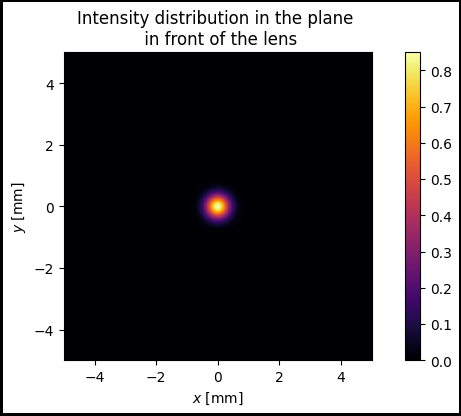

In [40]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, intensity_source, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Intensity distribution in the plane \n in front of the lens')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

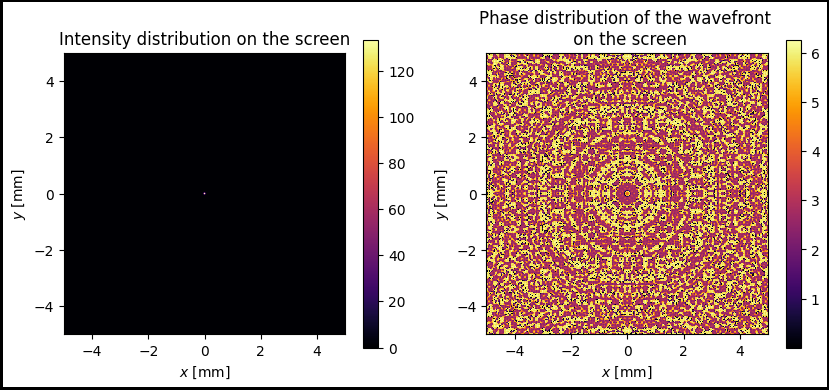

In [41]:
fig, ax = plt.subplots(
    1, 2, figsize=(10, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax[0].pcolormesh(xv, yv, intensity_target, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title(r'Intensity distribution on the screen')
ax[0].set_xlabel('$x$ [mm]')
ax[0].set_ylabel('$y$ [mm]')
fig.colorbar(im1)

im2 = ax[1].pcolormesh(xv, yv, phase_target, cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title('Phase distribution of the wavefront \n on the screen')
ax[1].set_xlabel('$x$ [mm]')
ax[1].set_ylabel('$y$ [mm]')
fig.colorbar(im2)

Use module phase_retrieval.py for solving the phase reconstruction problem with Hybrid-Input-Output algorithm:

In [42]:
# goal region on the screen
goal = torch.tensor((xv**2 + yv **2 <=3.1).astype(float))


phase_distribution = phase_retrieval.retrieve_phase(
    source_intensity=torch.tensor(intensity_source),
    optical_setup=optical_setup,
    target_intensity=torch.tensor(intensity_target),
    target_phase=torch.tensor(phase_target),
    target_region=torch.tensor(goal),
    initial_phase=None,
    method='HIO',
    maxiter=15,
    tol=1e-7
)

step = 2 * torch.pi / 256
mask = phase_distribution // step

C:\Users\gunne\AppData\Local\Temp\ipykernel_12872\2329981155.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_region=torch.tensor(goal),


Интенсивность на картинке выше справа должны получить после оптимизации

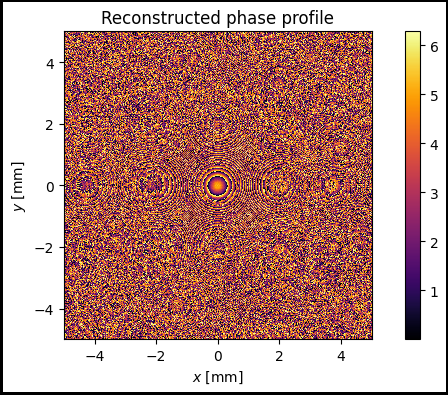

In [43]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, phase_distribution, cmap='inferno')
ax.set_aspect('equal')
ax.set_title(r'Reconstructed phase profile')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

Let us again solve the direct propagation problem, but using the reconstructed phase profile:

In [44]:
field_after_slm = elements.SpatialLightModulator(simulation_parameters=params, mask=mask).forward(field_before_lens1)

output_field = optical_setup.forward(field_after_slm)
intensity_target_opt = torch.pow(torch.abs(output_field), 2).detach().numpy()

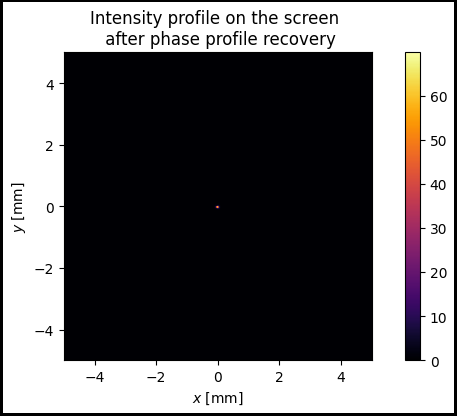

In [45]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, intensity_target_opt, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Intensity profile on the screen \n after phase profile recovery')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

Let's check the law of conservation of energy:

In [46]:
E1 = np.sum(intensity_target_opt) * dx * dy
E2 = np.sum(intensity_target) * dx * dy


0.3919136590406179
0.39191376953125


In [47]:
phase_opt = (torch.angle(output_field) + 2 * torch.pi * (torch.angle(output_field) < 0.).float()).detach().numpy()

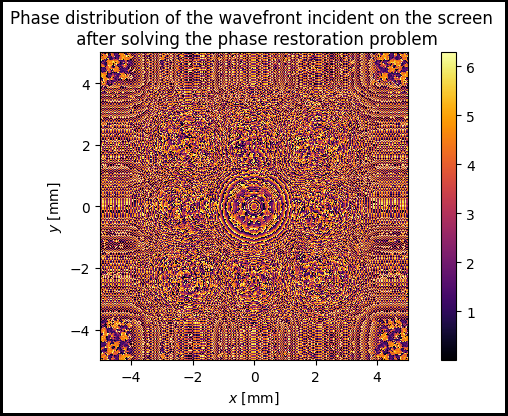

In [48]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, phase_opt, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Phase distribution of the wavefront incident on the screen \n after solving the phase restoration problem')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)